# **Forecasting**

Time series forecasting methods, such as ARIMA and Prophet, will be used to predict future sales for each category of product. 

Different methods of forecasting will be used here, they include: 
- Prophet forecasting model
- Arima forecasting model
- Holt-Winters (exponential smoothing)

Overall sales forecasting will be done and result will be compared on weekly and monthly basis. 

Brief Introduction to the models: 
- **Prophet Forecasting Model** Prophet is an open-source forecasting tool developed by Meta (facebook). It is designed to handle messy real-world time series data with missing values, outliers, and strong seasonal effects. 
- **ARIMA Forecasting Model** ARIMA Autoregressive integrated Moving Average is on of the most well known statistical models for time series forecasting. It uses 3 components: AR: uses past values. I: Differencing the series to make it stationary. MA: Uses past forecast errors. 
- **Exponential Smoothing (Holt-Winters)** exponential smoothing models assign exponentially decreasing weights to past observations. Holt-Winters adds the ability to model both trend and seasonality. 

Brief introduction to the evaluation metrics: 
- **MAE** - Mean absolute errors. It measures the average of the absolute differences between the actual and predicted values. 
- **RMSE** - Root Mean Squared Error. Similar to the MAE but penalizes larger errors more heavily because it squares the differences. 
- **MAPE** - Mean absolute percentage error. The average absolutes errors expressed as a percentage of actual values. 

**NOTE**: The smaller these values are, the better the model is at predicting future values, but what counts as "small" or "good" depends on the data.

### **Import Dependencies**

In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import xgboost as xgb
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
import pickle

In [2]:
df_laptop = pd.read_csv("../EDA/laptop_data.csv")
df_tablet = pd.read_csv("../EDA/tablet_data.csv")
df_smartphone = pd.read_csv("../EDA/smartphone_data.csv")
df_accessory = pd.read_csv("../EDA/accessory_data.csv")
model_df = pd.read_csv("../EDA/model_df.csv")
sales_by_date_category = pd.read_csv("../EDA/sales_by_date_category.csv")

In [3]:
sales_by_week_category = sales_by_date_category.copy()

sales_by_week_category['Date'] = sales_by_week_category['Date'].astype('datetime64[ns]')

sales_by_week_category['Date'] = sales_by_week_category['Date'].dt.to_period('W')

sales_by_week_category = sales_by_week_category.groupby(['Date', 'Category']).sum()['Sales_Volume'].reset_index()

sales_by_week_category['Date'] = sales_by_week_category['Date'].dt.to_timestamp()

sales_by_week_category.head(10)

,Date,Category,Sales_Volume
0,2008-12-29,Accessories,1405
1,2008-12-29,Laptop,1341
2,2008-12-29,Smartphone,1322
3,2008-12-29,Tablet,2070
4,2009-01-05,Accessories,3131
5,2009-01-05,Laptop,2297
6,2009-01-05,Smartphone,2483
7,2009-01-05,Tablet,2629
8,2009-01-12,Accessories,1323
9,2009-01-12,Laptop,2649


#### Split data into train and test sets

# **Univariate Forecasting**

#### Forecasting and Evaluating Weekly using Prophet Model

Here, forecasts will be done on each of the product categories. I will start with weekly forecast because:
- daily forecasting introduces a lot of short term fluctuations that may be difficult to control, 
- with weekly forecasts, I can easily aggregate sales for a short period of time and forecast easily, 
- the fluctuations in the sales volume will have been summed up into bigger values, easing the models training process. 

In [5]:
train_data_week = {}
test_data_week = {}

for category in sales_by_week_category['Category'].unique():
    category_data_weekly = sales_by_week_category[sales_by_week_category['Category'] == category][['Date', 'Sales_Volume']]
    
    category_data_weekly = category_data_weekly.rename(columns = {'Date': 'ds', 'Sales_Volume': 'y'})
    
    train_data_week[category] = category_data_weekly[category_data_weekly['ds'].dt.year < 2019]
    test_data_week[category] = category_data_weekly[category_data_weekly['ds'].dt.year >= 2019]

In [ ]:
# Print out train data dictionary
train_data_week

{'Accessories':              ds      y
 0    2008-12-29   1405
 4    2009-01-05   3131
 8    2009-01-12   1323
 12   2009-01-19   2823
 16   2009-01-26   3774
 ...         ...    ...
 2072 2018-12-03   5515
 2076 2018-12-10  10280
 2080 2018-12-17  10594
 2084 2018-12-24   8534
 2088 2018-12-31   3308
 
 [523 rows x 2 columns],
 'Laptop':              ds      y
 1    2008-12-29   1341
 5    2009-01-05   2297
 9    2009-01-12   2649
 13   2009-01-19   3549
 17   2009-01-26   2625
 ...         ...    ...
 2073 2018-12-03   5314
 2077 2018-12-10   9270
 2081 2018-12-17   7577
 2085 2018-12-24  10115
 2089 2018-12-31   3990
 
 [523 rows x 2 columns],
 'Smartphone':              ds     y
 2    2008-12-29  1322
 6    2009-01-05  2483
 10   2009-01-12  2874
 14   2009-01-19  2686
 18   2009-01-26  3281
 ...         ...   ...
 2074 2018-12-03  6733
 2078 2018-12-10  7457
 2082 2018-12-17  9494
 2086 2018-12-24  9679
 2090 2018-12-31  4371
 
 [523 rows x 2 columns],
 'Tablet':              ds  

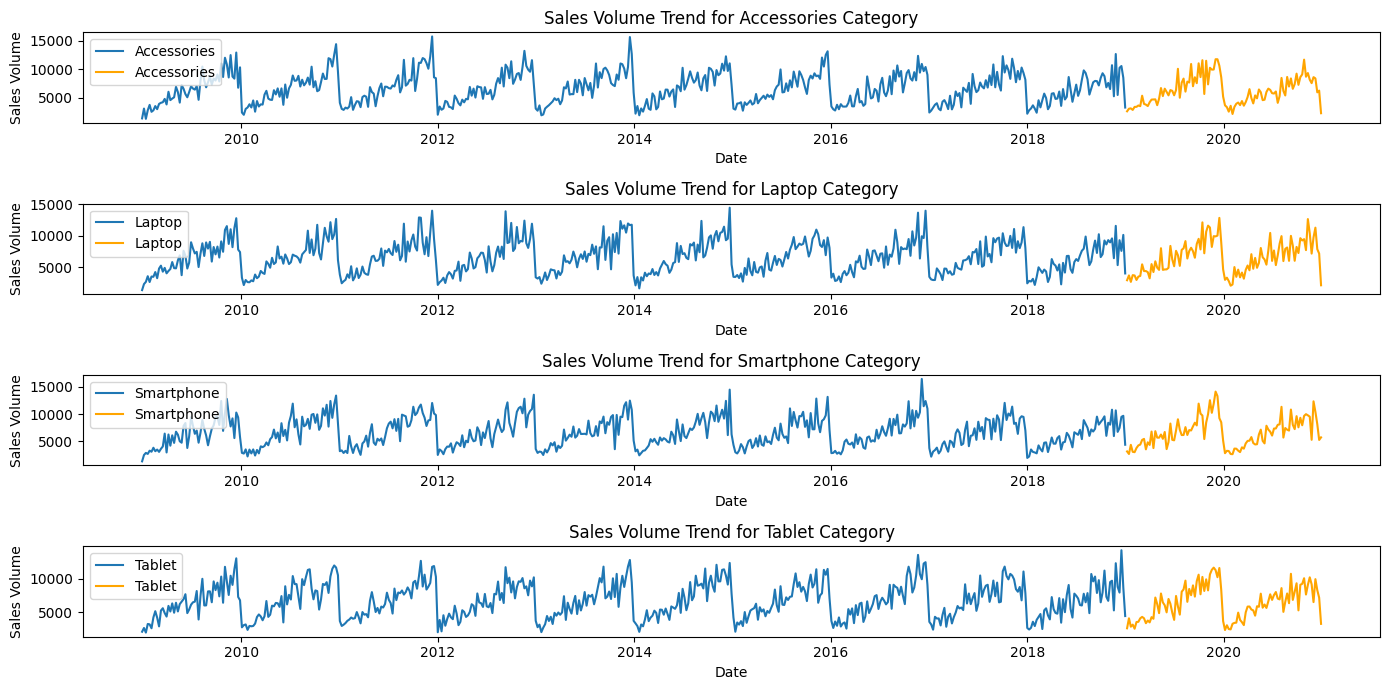

In [11]:
plt.figure(figsize=(14, 7))

for i in range(4): 
    category = sales_by_week_category['Category'].unique()[i]
    
    plt.subplot(4, 1, i+1)
    plt.plot(train_data_week[category]['ds'], train_data_week[category]['y'], label=category)
    plt.plot(test_data_week[category]['ds'], test_data_week[category]['y'], label=category, color = 'orange')
    plt.title(f'Sales Volume Trend for {category} Category')
    plt.xlabel('Date')
    plt.ylabel('Sales Volume')
    plt.legend()
    plt.tight_layout()
    
plt.show()

In [12]:
prophet_weekly_model = dict()

for category in sales_by_week_category['Category'].unique():
    model = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True) # add hyperparameters
    model.fit(train_data_week[category])
    prophet_weekly_model[category] = model

15:07:54 - cmdstanpy - INFO - Chain [1] start processing
15:07:59 - cmdstanpy - INFO - Chain [1] done processing
15:07:59 - cmdstanpy - INFO - Chain [1] start processing
15:07:59 - cmdstanpy - INFO - Chain [1] done processing
15:07:59 - cmdstanpy - INFO - Chain [1] start processing
15:07:59 - cmdstanpy - INFO - Chain [1] done processing
15:08:00 - cmdstanpy - INFO - Chain [1] start processing
15:08:00 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
prophet_weekly_model

{'Accessories': <prophet.forecaster.Prophet at 0x11c7feaa0>,
 'Laptop': <prophet.forecaster.Prophet at 0x10aef8b80>,
 'Smartphone': <prophet.forecaster.Prophet at 0x11c484370>,
 'Tablet': <prophet.forecaster.Prophet at 0x11c79c400>}

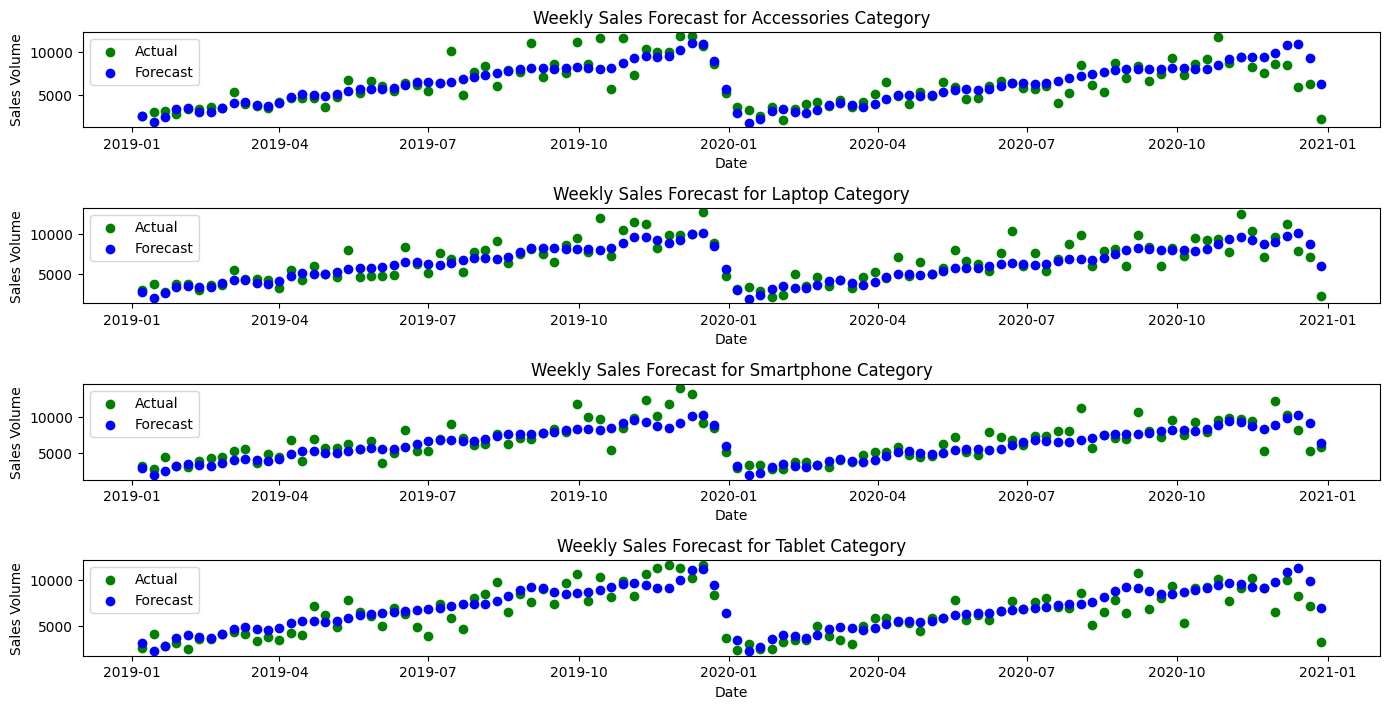

In [21]:
prophet_week_forecast = dict()

fig, ax = plt.subplots(4, 1, figsize=(14, 7))

for i in range(4):
    category = sales_by_week_category['Category'].unique()[i]
    
    prophet_week_forecast[category] = prophet_weekly_model[category].predict(test_data_week[category])
   
    ax[i].scatter(test_data_week[category]['ds'], test_data_week[category]['y'], label = 'Actual', color='green')
    ax[i].scatter(prophet_week_forecast[category]['ds'], prophet_week_forecast[category]['yhat'], label = 'Forecast', color='blue')
    
    plt.tight_layout()
    ax[i].set_title(f'Weekly Sales Forecast for {category} Category')
    ax[i].set_xlabel('Date')
    ax[i].set_ylabel('Sales Volume')
    ax[i].legend()
plt.show()

In [ ]:
# Evaluate the model performance using MAE, MAPE, and RMSE
mae, mape, rmse = 0,0,0

for category in sales_by_week_category['Category'].unique():
    mae += mean_absolute_error(test_data_week[category]['y'], prophet_week_forecast[category]['yhat'])
    mape += mean_absolute_percentage_error(test_data_week[category]['y'], prophet_week_forecast[category]['yhat'])
    rmse += root_mean_squared_error(test_data_week[category]['y'], prophet_week_forecast[category]['yhat'])
    
mae /= 4
mape /= 4
rmse /= 4

print(f'Mean Absolute Error (MAE): {round(mae, 2)}')
print(f'Mean Absolute Percentage Error (MAPE): {round(mape * 100, 2)} %')
print(f'Root Mean Squared Error (RMSE): {round(rmse, 2)}')

Mean Absolute Error (MAE): 1088.91
Mean Absolute Percentage Error (MAPE): 18.29 %
Root Mean Squared Error (RMSE): 1429.6


### **Forecasting and Evaluating Monthly using Prophet Model**

In this section, monthly forecasting will be done for each of the product categories. With monthly forecasts, sales can be easily aggregated and the fluctuations with daily and weekly data are lesser.

In [22]:
sales_by_month_category = sales_by_date_category.copy()

sales_by_month_category['Date'] = sales_by_month_category['Date'].astype('datetime64[ns]')

sales_by_month_category['Date'] = sales_by_month_category['Date'].dt.to_period('M')

sales_by_month_category = sales_by_month_category.groupby(['Date', 'Category']).sum()['Sales_Volume'].reset_index()

sales_by_month_category['Date'] = sales_by_month_category['Date'].dt.to_timestamp()

sales_by_month_category.head(10)

,Date,Category,Sales_Volume
0,2009-01-01,Accessories,11762
1,2009-01-01,Laptop,11989
2,2009-01-01,Smartphone,12192
3,2009-01-01,Tablet,12491
4,2009-02-01,Accessories,12086
5,2009-02-01,Laptop,14507
6,2009-02-01,Smartphone,13563
7,2009-02-01,Tablet,16043
8,2009-03-01,Accessories,18578
9,2009-03-01,Laptop,20525


In [23]:
train_data_month = {}
test_data_month = {}

for category in sales_by_month_category['Category'].unique():
    category_data_monthly = sales_by_month_category[sales_by_month_category['Category'] == category][['Date', 'Sales_Volume']]
    
    category_data_monthly = category_data_monthly.rename(columns = {'Date': 'ds', 'Sales_Volume': 'y'})
    
    train_data_month[category] = category_data_monthly[category_data_monthly['ds'].dt.year < 2019]
    test_data_month[category] = category_data_monthly[category_data_monthly['ds'].dt.year >= 2019]

In [24]:
prophet_monthly_model = dict()

for category in sales_by_month_category['Category'].unique():
    model = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True) # add hyperparameters
    model.fit(train_data_month[category])
    prophet_monthly_model[category] = model

16:10:18 - cmdstanpy - INFO - Chain [1] start processing
16:10:18 - cmdstanpy - INFO - Chain [1] done processing
16:10:18 - cmdstanpy - INFO - Chain [1] start processing
16:10:18 - cmdstanpy - INFO - Chain [1] done processing
16:10:18 - cmdstanpy - INFO - Chain [1] start processing
16:10:18 - cmdstanpy - INFO - Chain [1] done processing
16:10:18 - cmdstanpy - INFO - Chain [1] start processing
16:10:18 - cmdstanpy - INFO - Chain [1] done processing


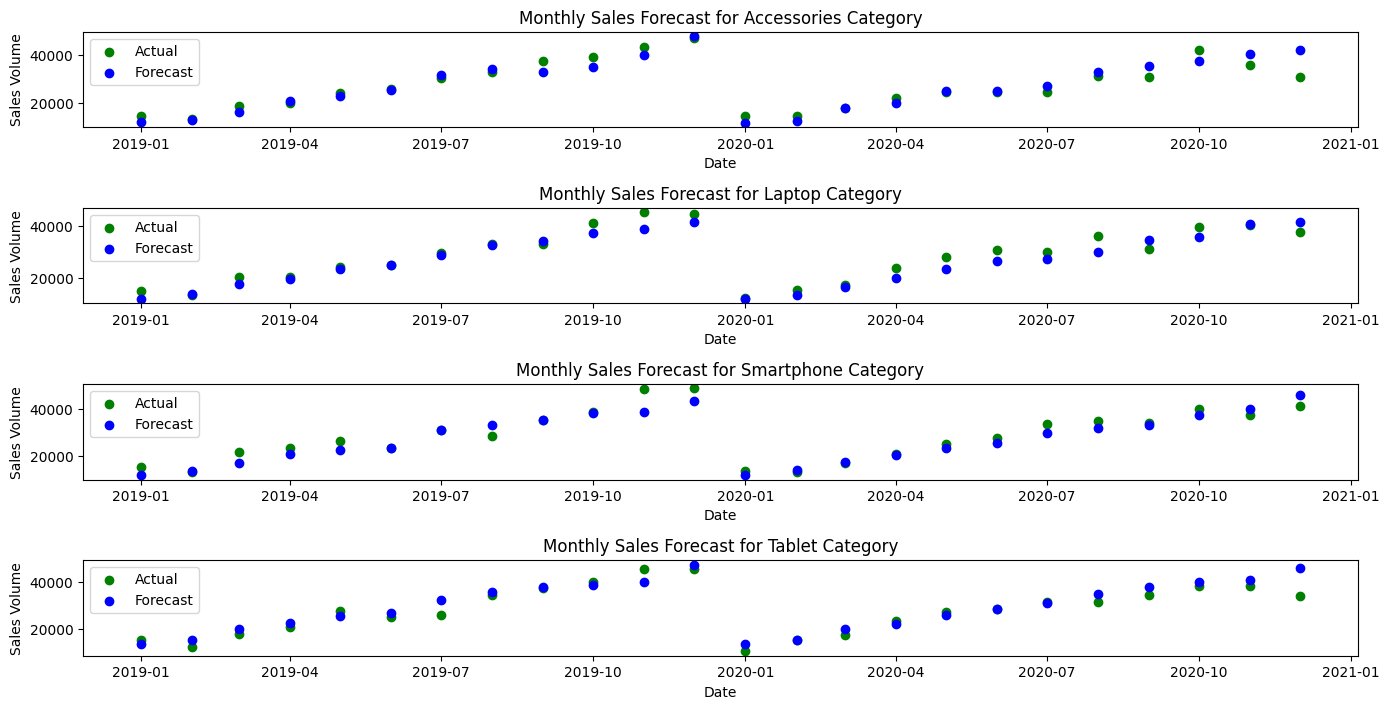

In [25]:
prophet_month_forecast = dict()

fig, ax = plt.subplots(4, 1, figsize=(14, 7))

for i in range(4):
    category = sales_by_month_category['Category'].unique()[i]
    
    prophet_month_forecast[category] = prophet_monthly_model[category].predict(test_data_month[category])
   
    ax[i].scatter(test_data_month[category]['ds'], test_data_month[category]['y'], label = 'Actual', color='green')
    ax[i].scatter(prophet_month_forecast[category]['ds'], prophet_month_forecast[category]['yhat'], label = 'Forecast', color='blue')
    
    plt.tight_layout()
    ax[i].set_title(f'Monthly Sales Forecast for {category} Category')
    ax[i].set_xlabel('Date')
    ax[i].set_ylabel('Sales Volume')
    ax[i].legend()
plt.show()

In [26]:
# Evaluate the model performance using MAE, MAPE, and RMSE
mae, mape, rmse = 0,0,0

for category in sales_by_month_category['Category'].unique():
    mae += mean_absolute_error(test_data_month[category]['y'], prophet_month_forecast[category]['yhat'])
    mape += mean_absolute_percentage_error(test_data_month[category]['y'], prophet_month_forecast[category]['yhat'])
    rmse += root_mean_squared_error(test_data_month[category]['y'], prophet_month_forecast[category]['yhat'])
    
mae /= 4
mape /= 4
rmse /= 4

print(f'Mean Absolute Error (MAE): {round(mae, 2)}')
print(f'Mean Absolute Percentage Error (MAPE): {round(mape * 100, 2)} %')
print(f'Root Mean Squared Error (RMSE): {round(rmse, 2)}')

Mean Absolute Error (MAE): 2503.28
Mean Absolute Percentage Error (MAPE): 9.07 %
Root Mean Squared Error (RMSE): 3370.85


Based on the evaluation metrics results for the weekly and monthly prophet model, the monthly model is better in this situation as it returned a lower MAPE percentage score. The MAE and RMSE score cannot really be used to determine a better model in this situation as the monthly model is dealing with larger values than the weekly so it is bound to have a higher error score. 

In [28]:
for category in sales_by_month_category['Category'].unique():
    with open(f'{category}_model.pkl', 'wb') as file:
        pickle.dump((prophet_monthly_model[category], train_data_month[category].columns), file)
        print(f'Model for {category} saved successfully.')
    

Model for Accessories saved successfully.
Model for Laptop saved successfully.
Model for Smartphone saved successfully.
Model for Tablet saved successfully.


### **Forecasting and Evaluating Weekly with ARIMA Model**

ARIMA stands for AutoRegressive Integrated Moving Average. 

Before building a model on ARIMA, it is necessary to check for stationarity in the dataset, as this is a requirement for using ARIMA. Stationarity here means that the statistical properties like mean and variance of the dataset do not change overtime. 

To do this stationarity test, the Augmented Dickey-Fuller test will be used. First, a function is defined to do this